In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, nsolve
from sympy import cosh, sin , sinh, cos,exp
from scipy.special import sph_harm,factorial
from scipy.optimize import fsolve
from scipy.integrate import quad,quad_vec
import numba
from decimal import Decimal, getcontext
getcontext().prec = 50  # 设置精度

In [58]:
e2=1.43997 ; hbarc=197.3269718 ; amu=931.49432
zp=55 ; Ap=112 ; mp=Ap*amu-46.41
z1=54 ; A1=111 ; m1=A1*amu-54.52    #1-> daughter
z2=1  ; A2=1   ; m2=A2*amu+7.288971064
Q=mp-m1-m2
mu=m1*m2/(m1+m2)

$\frac{\partial}{\partial \theta}Y_{l,m}(\theta,\phi)=\frac{1}{(2l+1)\sin\theta}\left [l(l-m+1)\frac{N_{l,m}}{N_{l+1,m}}Y_{l+1,m}(\theta,\phi)-(l+1)(l+m)\frac{N_{l,m}}{N_{l-1,m}}Y_{l-1,m}(\theta,\phi)]      \right],N_{l,m}=\sqrt{\frac{(2l+1)(l-m)!}{4\pi(l+m)!}}$

$V_{so}=V_{so0}\lambda_\pi^2\frac{1}{r}\frac{d}{dr}\frac{1}{1+\exp[(r-R_{so})/a_{so}]}\vec{\sigma}\cdot\vec{l}=\frac{V_{so0}\lambda_\pi^2}{a_{so}}\times \frac{-e^{\frac{r-R_{so}}{a_{so}}}}{r(1+e^{\frac{r-R_{so}}{a_{so}}})^2}\times\frac{J(J+1)-L(L+1)-S(S+1)}{2}$


In [59]:
Vso0=6.2 ; rso=1.01*(A1)**(1/3) ; aso=0.75 ; lambda_pi=np.sqrt(2)

In [60]:
Nlm=lambda l,m: np.sqrt((2*l+1)/(4*np.pi)*factorial(l-m)/factorial(l+m))
#derivative of Ylm on theta, theta exists on the denominator, so use epsilon to avoid division by zero
def dYlm(l,m,theta,phi):
    epsilon=1e-20
    return (1/(2*l+1)/(np.sin(theta)+epsilon))*(l*(l-m+1)*Nlm(l,m)/Nlm(l+1,m)*sph_harm(m,l+1,phi,theta)-(l+1)*(l+m)*Nlm(l,m)/Nlm(l-1,m)*sph_harm(m,l-1,phi,theta))

#deformed potential,with deformed paras beta, polarization params beta_tilde
def Vn(V0,r0,a0,beta2,beta4,beta2_tilde,beta4_tilde,r,theta):
    Y20=sph_harm(0, 2, 0, theta)  #sph_harm(m,l,phi,theta)
    Y40=sph_harm(0, 4, 0, theta)
    r0_theta=r0*(1+beta2*Y20+beta4*Y40)         #deformation

    # delta_theta=1e-6
    # dY20=(sph_harm(0, 2, 0, theta+delta_theta)-sph_harm(0, 2, 0, theta))/(delta_theta)
    # dY40=(sph_harm(0, 4, 0, theta+delta_theta)-sph_harm(0, 4, 0, theta))/(delta_theta)
    dY20=dYlm(2,0,theta,0)
    dY40=dYlm(4,0,theta,0)
    dr0_theta=r0*(beta2*dY20+beta4*dY40)       

# polarization
    a0_theta=a0*np.sqrt(1+(1/r0_theta*dr0_theta)**2)*(1+beta2_tilde*Y20+beta4_tilde*Y40) 

    return -V0/(1+np.exp((r-r0_theta)/a0_theta))

#V_{so}, with lambda_pi being the wave number of pion
def Vso(Vso0,rso,aso,lambda_pi,L,S,J,r):
    return Vso0*lambda_pi**2/aso*(-np.exp((r-rso)/aso)/(r*(1+np.exp((r-rso)/aso))**2))*(J*(J+1)-L*(L+1)-S*(S+1))/2


Piecewise $K_{\lambda}(r,\theta,\phi)$ with $m=0$ and deformed Coulomb

In [61]:
# def Vc(z1,z2,r,theta,Rc0,beta2,beta4):
#     Y00=sph_harm(0, 0, 0, theta)  
#     Y20=sph_harm(0, 2, 0, theta)  #sph_harm(m,l,phi,theta)
#     Y40=sph_harm(0, 4, 0, theta)
#     Rc=Rc0*(1+beta2*Y20+beta4*Y40)

#     def Klambda(lam,r,theta):
#         if lam==2 and r<=Rc:
#             res=r**2/5+r**2*np.log(Rc/r)
#         if lam!=2 and r<=Rc:
#             res=(2*lam+1)*r**2/(lam+3)/(lam-2)-r**lam*(lam-2)**(-1)/Rc**(lam-2)
#         else:
#             res=1/(lam+3)*Rc**(lam+3)/r**(lam+1)

#         return res
    
#     def integrand(theta, lam, r):
#         Ylam0 = sph_harm(0, lam, 0, theta)                    
#         K = Klambda(lam, r, theta)    
#         return Ylam0 * K * np.sin(theta)                    

#     res_0=2*quad(integrand,0,np.pi/2,args=(0,r))

#     res_2=2*quad(integrand,0,np.pi/2,args=(2,r))

#     res_4=2*quad(integrand,0,np.pi/2,args=(4,r))

#     result=3*z1*z2*e2/Rc**2*2*np.pi*(Y00*res_0+Y20/5*res_2+Y40/9*res_4)

#     return result



In [62]:
def Vc_vectorized(z1, z2, r, theta, Rc0, beta2, beta4):
    """
    Vectorized deformed-nucleus Coulomb potential.
    r can be scalar or any numpy array.
    """
    r = np.asarray(r)  # ensure array

    # Fixed outer angle (evaluation point)
    Y00 = sph_harm(0, 0, 0, theta).real
    Y20 = sph_harm(0, 2, 0, theta).real
    Y40 = sph_harm(0, 4, 0, theta).real
    Rc_fixed = Rc0 * (1 + beta2*Y20 + beta4*Y40)   # Rc at observation angle

    # Rc as function of integration variable
    def Rc_of_theta(t):
        return Rc0 * (1 + beta2*sph_harm(0,2,0,t).real + beta4*sph_harm(0,4,0,t).real)

    # Vectorized Kλ(l, r, θ_int)
    def Klambda(lam, rrr, t):
        Rc_t = np.maximum(Rc_of_theta(t), 1e-12)   # avoid ≤0
        inside = rrr <= Rc_t
        res = np.zeros_like(rrr)

        if lam == 2:
            res[inside]  = rrr[inside]**2/5 + rrr[inside]**2*np.log(Rc_t/rrr[inside])
            res[~inside] = Rc_t**(lam+3)/((lam+3)*rrr[~inside]**(lam+1))
        else:
            res[inside]  = (2*lam+1)*rrr[inside]**2/((lam+3)*(lam-2)) - rrr[inside]**lam/((lam-2)*Rc_t**(lam-2))
            res[~inside] = Rc_t**(lam+3)/((lam+3)*rrr[~inside]**(lam+1))
        return res

    # Integrand for given multipole λ
    def integrand_lam(t, lam):
        Yl0 = sph_harm(0, lam, 0, t).real
        return Yl0 * Klambda(lam, r, t) * np.sin(t)

    # Vectorized integration (0 → π/2, then ×2 for full sphere)
    res0 = 2 * quad_vec(lambda t: integrand_lam(t, 0), 0, np.pi/2,
                        epsabs=1e-10, epsrel=1e-10)[0]
    res2 = 2 * quad_vec(lambda t: integrand_lam(t, 2), 0, np.pi/2,
                        epsabs=1e-10, epsrel=1e-10)[0]
    res4 = 2 * quad_vec(lambda t: integrand_lam(t, 4), 0, np.pi/2,
                        epsabs=1e-10, epsrel=1e-10)[0]

    # Final Coulomb potential
    V = 3*z1*z2*e2 / Rc_fixed**2 * 2*np.pi * (
          Y00*res0 + Y20/5*res2 + Y40/9*res4)

    return V

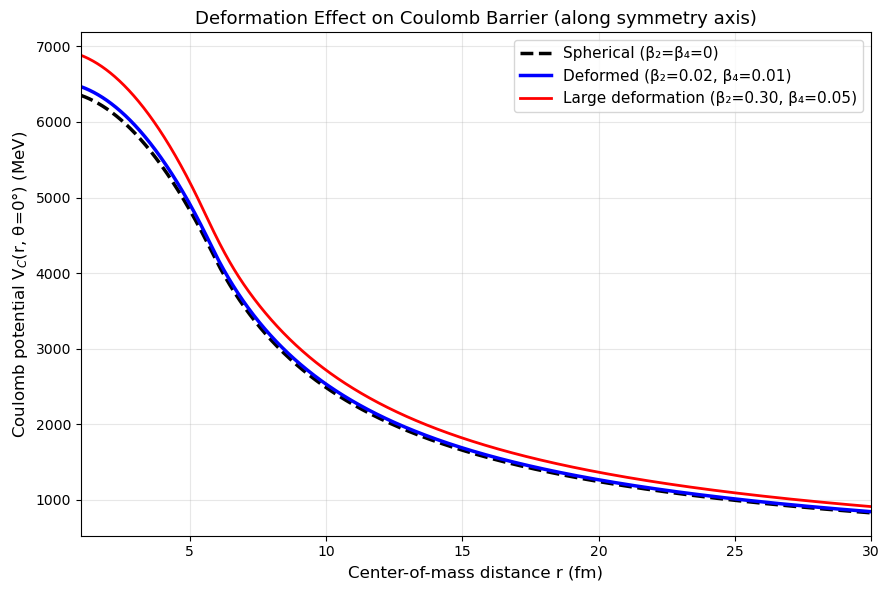

In [ ]:
# ================== 参数 ==================
z1, z2 = 54, 55
A1 = 111
Rc0 = 1.21 * A1**(1/3)          # ≈5.95 fm
theta_0 = np.pi/3                 # theta 度（沿长轴方向）
r = np.linspace(1.0, 30.0, 2000) # 避免 r 太小

# ================== 计算三条曲线 ==================
# 1. 未变形（球形核）
y_spherical = Vc_vectorized(z1, z2, r, theta_0, Rc0,
                            beta2=0.0, beta4=0.0)

# 2. 轻微变形（你原来的参数）
y_deformed = Vc_vectorized(z1, z2, r, theta_0, Rc0,
                           beta2=0.02, beta4=0.03)

# 3. （可选）更大的变形，方便对比
y_deformed_large = Vc_vectorized(z1, z2, r, theta_0, Rc0,
                                 beta2=0.30, beta4=0.05)

# ================== 绘图（只加这几行！）==================
plt.figure(figsize=(9, 6))

plt.plot(r, y_spherical, 'k--', lw=2.5, label='Spherical (β₂=β₄=0)')

plt.plot(r, y_deformed, 'b-', lw=2.5,
         label=fr'Deformed (β₂=0.02, β₄=0.01)')

# 如果想再加一条明显变形的，可以打开下面这行
plt.plot(r, y_deformed_large, 'r-', lw=2,
         label=fr'Large deformation (β₂=0.30, β₄=0.05)')

plt.xlabel('Center-of-mass distance r (fm)', fontsize=12)
plt.ylabel('Coulomb potential V$_C$(r, θ=0°) (MeV)', fontsize=12)
plt.title('Deformation Effect on Coulomb Barrier (along symmetry axis)', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(r.min(), r.max())
plt.tight_layout()
plt.show()